<a href="https://colab.research.google.com/github/ggrindstaff/Connectivity/blob/Automated-Earthwork-Detection/Colab_notebooks/Synthetic_BERM_PlottingCycles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies and import data

Install ripser package, cython dependency already available

In [ ]:
!git clone https://github.com/ggrindstaff/ripser.py
%cd ripser.py
!pip install -e .

fatal: destination path 'ripser.py' already exists and is not an empty directory.
/content/ripser.py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/ripser.py
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Running setup.py develop for ripser


In [ ]:
def img_to_sparse(img):
  # Modified from source code
    m, n = img.shape

    idxs = np.arange(m * n).reshape((m, n))

    I = idxs.flatten()
    J = idxs.flatten()
    V = img.flatten()

    # Connect 8 spatial neighbors
    tidxs = np.ones((m + 2, n + 2), dtype=np.int64) * np.nan
    tidxs[1:-1, 1:-1] = idxs

    tD = np.ones_like(tidxs) * np.nan
    tD[1:-1, 1:-1] = img

    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:

            if di == 0 and dj == 0:
                continue

            thisJ = np.roll(np.roll(tidxs, di, axis=0), dj, axis=1)
            thisD = np.roll(np.roll(tD, di, axis=0), dj, axis=1)
            thisD = np.maximum(thisD, tD)

            # Deal with boundaries
            boundary = ~np.isnan(thisD)
            thisI = tidxs[boundary]
            thisJ = thisJ[boundary]
            thisD = thisD[boundary]

            I = np.concatenate((I, thisI.flatten()))
            J = np.concatenate((J, thisJ.flatten()))
            V = np.concatenate((V, thisD.flatten()))

    return sparse.coo_matrix((V, (I, J)), shape=(idxs.size, idxs.size))


def cocycles_to_plot(cocycles,d,rotate=False):
  m,n = d.shape
  birthloc = [cocycles[0][i][0][0] for i in range(len(cocycles[0]))]
  xloc = []
  yloc = []
  for ind in birthloc:
    if rotate==False:
      yi = int(ind/n)
      xi = ind%n
    if rotate==True:
      yi = m-int(ind/n)-1
      xi = ind%n  
    xloc.append(xi)
    yloc.append(yi)
  return xloc,yloc

Code based on 
https://ripser.scikit-tda.org/en/latest/notebooks/Lower%20Star%20Image%20Filtrations.html

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import PIL
import random
# import latex

from persim import plot_diagrams, bottleneck, sliced_wasserstein, wasserstein, bottleneck_matching, PersImage,PersistenceImager, landscapes
from ripser import ripser, lower_star_img, Rips
from persim.persistent_entropy import *
from scipy import stats
from scipy import sparse


plt.rcParams.update(plt.rcParamsDefault)

# Load data and compute persistence diagrams

Takes about 0.07 seconds per image, for 100x100 pixel images. For berm data, about 6 seconds per image.

In [ ]:
directory = 'https://raw.githubusercontent.com/ggrindstaff/Connectivity/master/'#/content/Connectivity/Berms/'
name = 'berms'
files = ['Berms/OBJ2/DEM/AOI_OBJ2_untreated.csv',
         'Berms/OBJ2/DEM/AOI_OBJ2_untreated_AddedStruct.csv',
         'Berms/OBJ4/DEM/AOI_OBJ4_untreated.csv',
         'Berms/OBJ4/DEM/AOI_OBJ4_untreated_AddedStruct.csv',      
         ]

N=len(files)

import scipy.ndimage

dgm0 = {i:[] for i in range(N)} # output 0th homology data
dgm0_adj= {i:[] for i in range(N)} # output 0th homology data
dgm1 = {i:[] for i in range(N)} # output 1th homology data
data = {i:[] for i in range(N)} # DEM data for examples
data2 = {i:[] for i in range(N)} # DEM data with noise for examples
cocycles = {i:[] for i in range(N)}

for i in range(N):
  data[i] = np.loadtxt(directory+files[i],delimiter=",",skiprows=1)
  if i>3:
    d = ndimage.interpolation.zoom(data[i],.5) #decimate resolution
  else:
    d = data[i]
  data2[i] = d + 0.00001*np.random.rand(d.shape[0],d.shape[1])
  if 'stockpond' in files[i]:
    dgm0[i] = lower_star_img(data2[i])    #sublevel set filtration
  #  dgm1[i] = lower_star_img(-data2[i],1) #1st homology of superlevel set
  else:
    sparseDM = img_to_sparse(data2[i])
    rip = ripser(-sparseDM, distance_matrix=True, maxdim=0, do_cocycles=True)
    dgm0[i] = rip["dgms"][0]
    cocycles[i] = rip["cocycles"]
 

#Plot cycle locations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in subtract


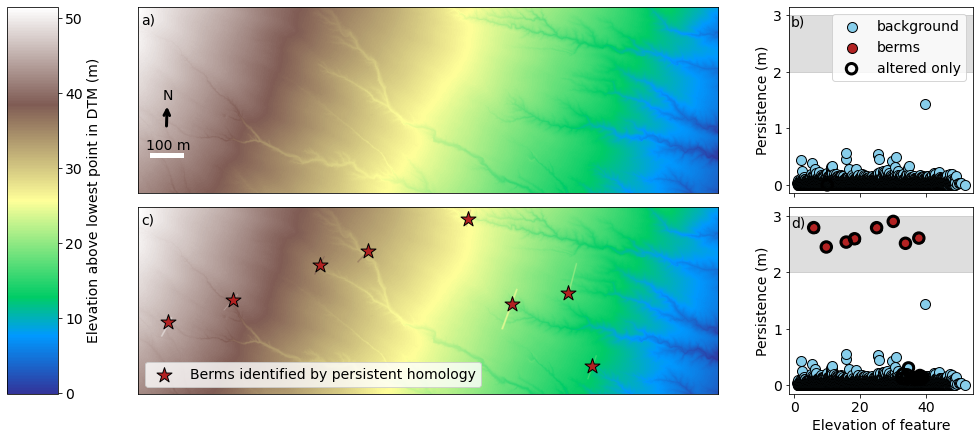

In [ ]:
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rcParams.update({'font.size': 14})

thresh = 2
max_thresh = 3
minelev = 48
cmap='terrain'

fig2 = plt.figure(constrained_layout=True, figsize = (13.5,6))
spec2 = gridspec.GridSpec(ncols=10, nrows=2, figure=fig2)
ax0 = fig2.add_subplot(spec2[:, 0]) # this is the colorbar
ax1 = fig2.add_subplot(spec2[0, 1:8]) # this is the elevation image without berms
ax2 = fig2.add_subplot(spec2[1, 1:8]) # elevation image with berms
ax3 = fig2.add_subplot(spec2[0, 8:]) # PD without berms
ax4 = fig2.add_subplot(spec2[1, 8:]) # PD with berms

textlabel = ['a)','c)',]
axs = [ax1,ax2]
for i in range(2):
  j = i+2
  ax = axs[i]
  shw = ax.imshow(data2[j]+minelev, cmap = cmap)
  ax.text(10,60,textlabel[i],fontsize=14,c='black')
  ax.set_xticks([])
  ax.set_yticks([])
  idxs = np.arange(dgm0[j].shape[0])
  idxs = idxs[np.abs(dgm0[j][:, 1] - dgm0[j][:, 0]) > thresh]
  xcycle=[]
  ycycle=[]
  counter = 0
  for idx in idxs:
    if np.abs(dgm0[j][idx, 1] - dgm0[j][idx, 0])<max_thresh:
      counter = counter+1
    #  note: change sign for superlevel set filtration
      #birthy,birthx = np.unravel_index(np.argmin(np.abs(data2[i]+dgm0[i][idx,0])),data2[i].shape)
      data3 = abs(data2[j]+dgm0[j][idx,0])
      x,y = np.where(data3 == np.min(data3))
      if len(x)!=1:
       print("Location Error at "+idx)
      else: 
        xcycle.append(y) 
        ycycle.append(x) 
  ax.scatter(xcycle,ycycle,color='firebrick', marker='*',clip_on=False,
             s=250,edgecolor = 'k',label = 'Berms identified by persistent homology')
  if i==0:
    
    ax.plot([50,150],[520,520],lw=5,c='white')
    ax.text(30,500,'100 m')
  else:
    ax.legend(loc='lower left')

cbar = plt.colorbar(shw, cax=ax0, shrink=1)
cbar.set_label('Elevation above lowest point in DTM (m)')


birth_original = np.array([p[0] for p in dgm0[0+2]])
death_original = np.array([p[1] for p in dgm0[0+2]])
birth_synth = np.array([p[0] for p in dgm0[1+2]])
death_synth = np.array([p[1] for p in dgm0[1+2]])
persistence_original = death_original-birth_original
persistence_synth = death_synth-birth_synth
mask_original = (persistence_original>=thresh) & (persistence_original<=max_thresh)
mask_synth = (persistence_synth>=thresh) & (persistence_synth<=max_thresh)
dgm_berm_original = dgm0[0+2][mask_original]
dgm_berm_synth = dgm0[1+2][mask_synth]

birth_original_berm = np.array([p[0] for p in dgm_berm_original])
death_original_berm = np.array([p[0] for p in dgm_berm_original])
birth_synth_berm = np.array([p[0] for p in dgm_berm_synth])
death_synth_berm = np.array([p[1] for p in dgm_berm_synth])
pers_original_berm = death_original_berm-birth_original_berm
pers_synth_berm = death_synth_berm-birth_synth_berm

births = [birth_original,birth_synth]
deaths = [death_original,death_synth]
persistence = [persistence_original,persistence_synth]

births_berm = [birth_original_berm,birth_synth_berm]
deaths_berm = [death_original_berm,death_synth_berm]
persistence_berm = [pers_original_berm,pers_synth_berm]

lendiff = len(births[1])-len(births[0])
birth_diff = []
death_diff = []
for i in range(len(births[1])):
  if persistence_synth[i]>0.1:
    diffs = np.array(births[0][max(i-lendiff,0):i+1]) - births[1][i]
    diffmask = (diffs<0.1)
    if (min(diffs)<0.1):
      deathdiff = (np.array(deaths[0][max(i-lendiff,0):i+1]) - deaths[1][i])[diffmask]
      if (np.isfinite(min(deathdiff))) & (min(deathdiff)>0.1):
        birth_diff.append(births[1][i])
        death_diff.append(deaths[1][i])
    else:
      birth_diff.append(births[1][i])
      death_diff.append(deaths[1][i])
birth_diff = np.array(birth_diff)
death_diff = np.array(death_diff)

keys = [0,1]
axs = [ax3,ax4]
textlabel = ['b)','d)']
for key in keys:
  ax = axs[key]
  #Plot horizontal
  ax.scatter((births[key]+deaths[key])/2+4.5,
            persistence[key],
            label='background',c='skyblue',edgecolor = 'k',s=100, )
  ax.scatter((births_berm[key]+deaths_berm[key])/2+4.5,
             persistence_berm[key],c='firebrick',edgecolor='k',s=100,label='berms')
  if key==1:
    ax.scatter((birth_diff+death_diff)/2+4.5,
               (death_diff-birth_diff),c='none',edgecolor = 'k',
               s=110,label = 'altered only',lw=3)
  else:
    ax.scatter([10],[0],c='none',edgecolor = 'k',
               s=110,label = 'altered only',lw=3)
  ax.axhspan(2,3,
                 facecolor='k',alpha=0.13,edgecolor = 'k',zorder = -1)
  ax.set_ylabel("Persistence (m)")
  ax.text(-1,2.8,textlabel[key],fontsize = 14)
  i = i+1
  if key==0:
    ax.legend(loc='upper right')


axs[0].set_xticklabels([]) 
axs[1].set_xlabel("Elevation of feature")

ax1.annotate('N', (100, 425),
            xytext=(85, 325),
             arrowprops=dict(facecolor='black', 
                             arrowstyle='<-',
                             lw = 3))


plt.savefig('synthetic_berms_1.png',format='png',dpi=300,bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in subtract


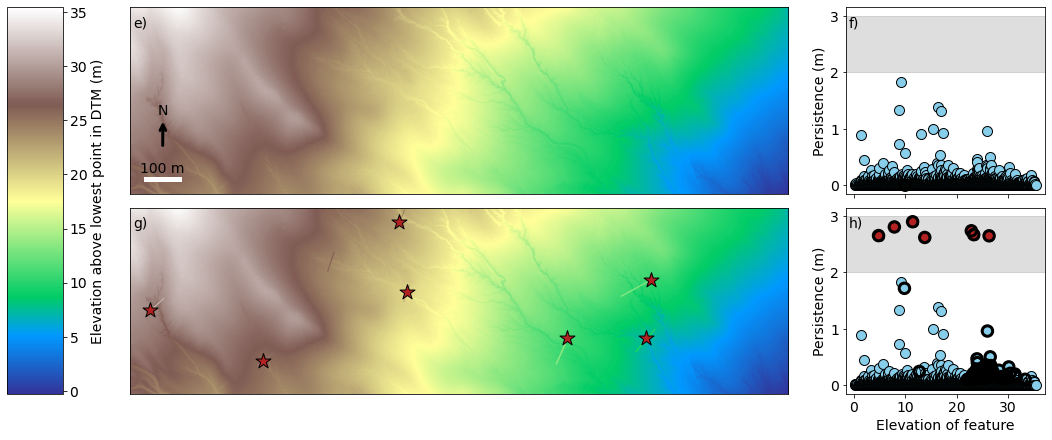

In [ ]:
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rcParams.update({'font.size': 14})

thresh = 2
max_thresh = 3
minelev = 31
cmap='terrain'

fig2 = plt.figure(constrained_layout=True, figsize = (14.5,6))
spec2 = gridspec.GridSpec(ncols=10, nrows=2, figure=fig2)
ax0 = fig2.add_subplot(spec2[:, 0]) # this is the colorbar
ax1 = fig2.add_subplot(spec2[0, 1:8]) # this is the elevation image without berms
ax2 = fig2.add_subplot(spec2[1, 1:8]) # elevation image with berms
ax3 = fig2.add_subplot(spec2[0, 8:]) # PD without berms
ax4 = fig2.add_subplot(spec2[1, 8:]) # PD with berms

textlabel = ['e)','g)',]
axs = [ax1,ax2]
for i in range(2):
  ax = axs[i]
  shw = ax.imshow(data2[i]+minelev, cmap = cmap)
  ax.text(10,60,textlabel[i],fontsize=14,c='black')
  ax.set_xticks([])
  ax.set_yticks([])
  idxs = np.arange(dgm0[i].shape[0])
  idxs = idxs[np.abs(dgm0[i][:, 1] - dgm0[i][:, 0]) > thresh]
  xcycle=[]
  ycycle=[]
  counter = 0
  for idx in idxs:
    if np.abs(dgm0[i][idx, 1] - dgm0[i][idx, 0])<max_thresh:
      counter = counter+1
    #  note: change sign for superlevel set filtration
      #birthy,birthx = np.unravel_index(np.argmin(np.abs(data2[i]+dgm0[i][idx,0])),data2[i].shape)
      data3 = abs(data2[i]+dgm0[i][idx,0])
      x,y = np.where(data3 == np.min(data3))
      xcycle.append(y) 
      ycycle.append(x) 
  ax.scatter(xcycle,ycycle,color='firebrick', marker='*',clip_on=False,
             s=250,edgecolor = 'k',label = 'Berms identified by persistent homology')
  if i==0:
    
    ax.plot([50,150],[520,520],lw=5,c='white')
    ax.text(30,500,'100 m')
  # else:
  #   ax.legend(loc='upper right')

cbar = plt.colorbar(shw, cax=ax0, shrink=1)
cbar.set_label('Elevation above lowest point in DTM (m)')


birth_original = np.array([p[0] for p in dgm0[0]])
death_original = np.array([p[1] for p in dgm0[0]])
birth_synth = np.array([p[0] for p in dgm0[1]])
death_synth = np.array([p[1] for p in dgm0[1]])
persistence_original = death_original-birth_original
persistence_synth = death_synth-birth_synth
mask_original = (persistence_original>=thresh) & (persistence_original<=max_thresh)
mask_synth = (persistence_synth>=thresh) & (persistence_synth<=max_thresh)
dgm_berm_original = dgm0[0][mask_original]
dgm_berm_synth = dgm0[1][mask_synth]

birth_original_berm = np.array([p[0] for p in dgm_berm_original])
death_original_berm = np.array([p[0] for p in dgm_berm_original])
birth_synth_berm = np.array([p[0] for p in dgm_berm_synth])
death_synth_berm = np.array([p[1] for p in dgm_berm_synth])
pers_original_berm = death_original_berm-birth_original_berm
pers_synth_berm = death_synth_berm-birth_synth_berm

births = [birth_original,birth_synth]
deaths = [death_original,death_synth]
persistence = [persistence_original,persistence_synth]

births_berm = [birth_original_berm,birth_synth_berm]
deaths_berm = [death_original_berm,death_synth_berm]
persistence_berm = [pers_original_berm,pers_synth_berm]

lendiff = len(births[1])-len(births[0])
birth_diff = []
death_diff = []
for i in range(len(births[1])):
  if persistence_synth[i]>0.1:
    diffs = np.array(births[0][max(i-lendiff,0):i+1]) - births[1][i]
    diffmask = (diffs<0.1)
    if (min(diffs)<0.1):
      deathdiff = (np.array(deaths[0][max(i-lendiff,0):i+1]) - deaths[1][i])[diffmask]
      if (np.isfinite(min(deathdiff))) & (min(deathdiff)>0.1):
        birth_diff.append(births[1][i])
        death_diff.append(deaths[1][i])
    else:
      birth_diff.append(births[1][i])
      death_diff.append(deaths[1][i])
birth_diff = np.array(birth_diff)
death_diff = np.array(death_diff)

keys = [0,1]
axs = [ax3,ax4]
textlabel = ['f)','h)']
for key in keys:
  ax = axs[key]
  #Plot horizontal
  ax.scatter((births[key]+deaths[key])/2+4.5,
            persistence[key],
            label='background',c='skyblue',edgecolor = 'k',s=100, )
  ax.scatter((births_berm[key]+deaths_berm[key])/2+4.5,
             persistence_berm[key],c='firebrick',edgecolor='k',s=100,label='berms')
  if key==1:
    ax.scatter((birth_diff+death_diff)/2+4.5,
               (death_diff-birth_diff),c='none',edgecolor = 'k',
               s=110,label = 'altered only',lw=3)
  else:
    ax.scatter([10],[0],c='none',edgecolor = 'k',
               s=110,label = 'altered only',lw=3)
  ax.axhspan(2,3,
                 facecolor='k',alpha=0.13,edgecolor = 'k',zorder = -1)
  ax.set_ylabel("Persistence (m)")
  ax.text(-1,2.8,textlabel[key],fontsize = 14)
  i = i+1
  # if key==0:
  #   ax.legend(loc='upper right')


axs[0].set_xticklabels([]) 
axs[1].set_xlabel("Elevation of feature")

ax1.annotate('N', (100, 425),
            xytext=(85, 325),
             arrowprops=dict(facecolor='black', 
                             arrowstyle='<-',
                             lw = 3))


plt.savefig('synthetic_berms.png',format='png',dpi=300,bbox_inches='tight')

In [ ]:
def persitence_subs(dgm_original,dgm_altered,idxs,mask0,mask1):
  birth_original = np.array([p[0] for p in dgm_original])[mask0]
  death_original = np.array([p[1] for p in dgm_original])[mask0]
  birth_synth = np.array([p[0] for p in dgm_altered])[mask1]
  death_synth = np.array([p[1] for p in dgm_altered])[mask1]
  persistence_original = death_original-birth_original
  persistence_synth = death_synth-birth_synth
  mask_original = (False)
  mask_synth = (persistence_synth>=thresh) & (persistence_synth<=max_thresh)
  dgm_berm_original = dgm_original[mask_original]
  dgm_berm_synth = dgm_altered[idxs]

  birth_original_berm = np.array([p[0] for p in dgm_berm_original])
  death_original_berm = np.array([p[0] for p in dgm_berm_original])
  birth_synth_berm = np.array([p[0] for p in dgm_berm_synth])
  death_synth_berm = np.array([p[1] for p in dgm_berm_synth])
  pers_original_berm = death_original_berm-birth_original_berm
  pers_synth_berm = death_synth_berm-birth_synth_berm

  births = [birth_original,birth_synth]
  deaths = [death_original,death_synth]
  persistence = [persistence_original,persistence_synth]

  births_berm = [birth_original_berm,birth_synth_berm]
  deaths_berm = [death_original_berm,death_synth_berm]
  persistence_berm = [pers_original_berm,pers_synth_berm]
  return births,deaths,persistence,births_berm,deaths_berm,persistence_berm

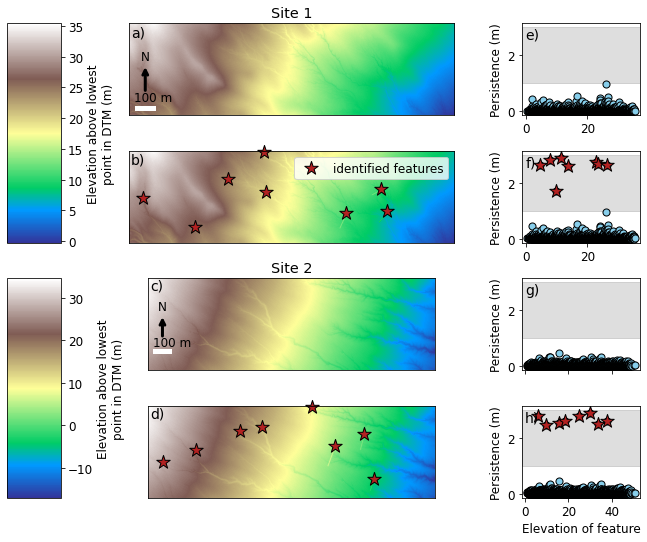

In [ ]:
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rcParams.update({'font.size': 12})

thresh = 1
max_thresh = 3
noisethresh = 7
minelev = 31
cmap='terrain'

fig2 = plt.figure(figsize = (7.25*1.3,5*1.5))
spec2 = gridspec.GridSpec(ncols=19, nrows=4, figure=fig2)
ax0 = fig2.add_subplot(spec2[:2, 0]) # this is the colorbar
ax1 = fig2.add_subplot(spec2[0, 1:16]) # this is the elevation image without berms
ax2 = fig2.add_subplot(spec2[1, 1:16]) # elevation image with berms
ax3 = fig2.add_subplot(spec2[0, 16:]) # PD without berms
ax4 = fig2.add_subplot(spec2[1, 16:]) # PD with berms

ax5 = fig2.add_subplot(spec2[2:, 0]) # this is the colorbar
ax6 = fig2.add_subplot(spec2[2, 1:16]) # this is the elevation image without berms
ax7 = fig2.add_subplot(spec2[3, 1:16]) # elevation image with berms
ax8 = fig2.add_subplot(spec2[2, 16:]) # PD without berms
ax9 = fig2.add_subplot(spec2[3, 16:]) # PD with berms

idx_save = []

textlabel = ['a)','b)','c)','d)']
axs = [ax1,ax2,ax6,ax7]
masks = []
for i in range(4):
  ax = axs[i]
  if i<2:
    shw = ax.imshow(data2[i]+minelev, cmap = cmap)
  else:
    shw1 = ax.imshow(data2[i]+minelev, cmap = cmap)
  ax.text(10,80,textlabel[i],fontsize=14,c='black')
  ax.set_xticks([])
  ax.set_yticks([])
  idxs = np.arange(dgm0[i].shape[0])
  idxs = idxs[np.abs(dgm0[i][:, 1] - dgm0[i][:, 0]) > thresh]
  xvals, yvals = cocycles_to_plot(cocycles[i],data2[i],rotate=False)
  xvals, yvals = np.array(xvals), np.array(yvals)
  mask_all = (xvals>noisethresh)&(xvals<len(data2[i][0])-noisethresh)&(yvals>noisethresh)&(yvals<len(data2[i])-noisethresh)
  masks.append(mask_all)
  xcycle = np.array(xvals)[idxs]
  ycycle = np.array(yvals)[idxs]
  mask = (xcycle>noisethresh)&(xcycle<len(data2[i][0])-noisethresh)&(ycycle>noisethresh)&(ycycle<len(data2[i])-noisethresh)
  xcycle = xcycle[mask]
  ycycle = ycycle[mask]
  idxs = idxs[mask]
  idx_save.append(idxs)
  counter = len(xcycle)
  ax.scatter(xcycle,ycycle,color='firebrick', marker='*',clip_on=False,
             s=200,edgecolor = 'k',label = 'identified features',
             )
  if i in [0,2]:
    ax.plot([50,150],[520,520],lw=5,c='white')
    ax.text(30,480,'100 m')
  elif i==1:
    ax.legend(loc='upper right')

cbar = fig2.colorbar(shw, cax=ax0, shrink=1)
cbar.set_label('Elevation above lowest\npoint in DTM (m)')

cbar = fig2.colorbar(shw1, cax=ax5, shrink=1)
cbar.set_label('Elevation above lowest\npoint in DTM (m)')

births,deaths,persistence,births_berm,deaths_berm,persistence_berm = persitence_subs(dgm0[0],dgm0[1],idx_save[1],masks[0],masks[1])

keys = [0,1]
axs = [ax3,ax4]
textlabel = ['e)','f)']
for key in keys:
  ax = axs[key]
  #Plot horizontal
  ax.scatter((births[key]+deaths[key])/2+4.5,
            persistence[key],
            label='background',c='skyblue',edgecolor = 'k',s=50, )
  ax.scatter((births_berm[key]+deaths_berm[key])/2+4.5,
             persistence_berm[key],c='firebrick',edgecolor='k',s=200,label='berms',
             marker = '*')
  ax.axhspan(thresh,max_thresh,
                 facecolor='k',alpha=0.13,edgecolor = 'k',zorder = -1)
  ax.set_ylabel("Persistence (m)")
  ax.text(0,2.6,textlabel[key],fontsize = 14)
  i = i+1
  # if key==0:
  #   ax.legend(loc='upper right')

births,deaths,persistence,births_berm,deaths_berm,persistence_berm = persitence_subs(dgm0[2],dgm0[3],idx_save[3],masks[2],masks[3])

keys = [0,1]
axs = [ax8,ax9]
textlabel = ['g)','h)']
for key in keys:
  ax = axs[key]
  #Plot horizontal
  ax.scatter((births[key]+deaths[key])/2+4.5,
            persistence[key],
            label='background',c='skyblue',edgecolor = 'k',s=50, )
  ax.scatter((births_berm[key]+deaths_berm[key])/2+4.5,
             persistence_berm[key],c='firebrick',edgecolor='k',s=200,label='berms',
             marker = '*')
  ax.axhspan(thresh,max_thresh,
                 facecolor='k',alpha=0.13,edgecolor = 'k',zorder = -1)
  ax.set_ylabel("Persistence (m)")
  ax.text(0,2.6,textlabel[key],fontsize = 14)
  i = i+1


axs[0].set_xticklabels([]) 
axs[1].set_xlabel("Elevation of feature")

ax1.annotate('N', (100, 425),
            xytext=(100, 225),
             arrowprops=dict(facecolor='black', 
                             arrowstyle='<-',
                             lw = 3),ha = 'center')

ax6.annotate('N', (100, 425),
            xytext=(100, 225),
             arrowprops=dict(facecolor='black', 
                             arrowstyle='<-',
                             lw = 3), ha='center')

fig2.tight_layout()
plt.subplots_adjust(wspace=-.4)

ax1.set_title('Site 1')
ax6.set_title('Site 2')

plt.savefig('synthetic_berms.png',format='png',dpi=300,bbox_inches='tight')